In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data # yahoo finance data download
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# for finite difference
from scipy.sparse import diags
from scipy.linalg import solve_triangular

# normal distribution
from scipy.stats import norm

from google.colab import drive
# for downloading files from google colab
from google.colab import files

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import array, newaxis

In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Underlying Data Download

In [ ]:
tickers = ["FB"]
start_date = '2011-01-01'
end_date = '2019-06-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, "yahoo", start_date, end_date)

In [ ]:
num_dates = len(panel_data)
sigma_lists = []
rolling_window = 30
for ticker in tickers:
    price_list = panel_data[("Adj Close", ticker)].to_list()
    return_list = [None for x in range(len(price_list)-1)]
    sigma_list = [None for x in range(num_dates)]
    for i in range(1, len(price_list)):
        return_list[i-1] = np.log(price_list[i]/price_list[i-1])
    for date_index in range(rolling_window):
        sigma_list[date_index] = 0
    for date_index in range(rolling_window, num_dates):
        sigma = np.std(return_list[-rolling_window+date_index:date_index])
        sigma_list[date_index] = sigma * np.sqrt(252)
    sigma_lists.append(sigma_list)
sigma_df = pd.DataFrame(np.transpose(sigma_lists), columns=tickers, index=panel_data.index[:])

In [ ]:
sigma_df.head()

,FB
Date,
2012-05-18,0.0
2012-05-21,0.0
2012-05-22,0.0
2012-05-23,0.0
2012-05-24,0.0


# Data Preparation

## Reconfiguration

In [ ]:
factor_df = pd.read_csv("/content/drive/My Drive/Data/factor_data.csv")
factor_df.head()

,Unnamed: 0,Unnamed: 0.1,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,level,optionid,forward_price,index_flag,issuer,exercise_style,timeStampDate,underlying_adj_close_price,underlying_close_price,underlying_high_price,underlying_low_price,underlying_open_price,underlying_volume,T,t,bid_ask_spread,tau,moneyness,option_price,diff,skew,convexity
0,6,8348,154402,20120702,20120706,20120702,C,31.0,0.3,0.35,3120,0.333024,82494690,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,4,0,0.05,4,1.007420,0.325,0.23,0.058452,0.233808
1,26,8380,154402,20120702,20120721,20120702,C,31.0,1.0,1.05,3443,0.414648,81935010,30.774592,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,19,0,0.05,19,1.007324,1.025,0.23,0.011407,0.045628
2,50,8421,154402,20120702,20120818,20120702,C,31.0,2.3,2.35,1416,0.556667,81935092,30.785786,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,47,0,0.05,47,1.006958,2.325,0.23,0.004907,0.019628
3,80,8462,154402,20120702,20120922,20120702,C,31.0,2.8,2.85,68,0.505135,81935174,30.799767,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,82,0,0.05,82,1.006501,2.825,0.23,0.010038,0.040152
4,103,8503,154402,20120702,20121020,20120702,C,31.0,3.1,3.30,37,0.490870,82080337,30.811287,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,110,0,0.20,110,1.006125,3.200,0.23,0.005980,0.023920


In [ ]:
# Get VIX data
start_date = '2012-07-02'
end_date = '2019-06-30'
VIX_df = data.DataReader('^VIX', 'yahoo', start_date, end_date)
VIX_df = VIX_df[['Adj Close']]

In [ ]:
VIX_df.head()

,Adj Close
Date,
2012-07-02,16.799999
2012-07-03,16.660000
2012-07-05,17.500000
2012-07-06,17.100000
2012-07-09,17.980000


In [ ]:
# Incorporate estimated volatility
factor_df["underlying_volatility"] = factor_df.apply(lambda row: sigma_df.loc[row.timeStampDate, 'FB'], axis=1)
# Incorporate VIX
factor_df["VIX"] = factor_df.apply(lambda row: VIX_df.loc[row.timeStampDate, 'Adj Close'], axis=1)
# Incorporate weights
factor_df["weight"] = 1 / factor_df.bid_ask_spread

In [ ]:
factor_df.drop(factor_df[factor_df.bid_ask_spread <= 0].index, inplace=True)

In [ ]:
factor_df.head()

,Unnamed: 0,Unnamed: 0.1,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,level,optionid,forward_price,index_flag,issuer,exercise_style,timeStampDate,underlying_adj_close_price,underlying_close_price,underlying_high_price,underlying_low_price,underlying_open_price,underlying_volume,T,t,bid_ask_spread,tau,moneyness,option_price,diff,skew,convexity,underlying_volatility,VIX,weight
0,6,8348,154402,20120702,20120706,20120702,C,31.0,0.3,0.35,3120,0.333024,82494690,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,4,0,0.05,4,1.007420,0.325,0.23,0.058452,0.233808,0.702614,16.799999,20.0
1,26,8380,154402,20120702,20120721,20120702,C,31.0,1.0,1.05,3443,0.414648,81935010,30.774592,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,19,0,0.05,19,1.007324,1.025,0.23,0.011407,0.045628,0.702614,16.799999,20.0
2,50,8421,154402,20120702,20120818,20120702,C,31.0,2.3,2.35,1416,0.556667,81935092,30.785786,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,47,0,0.05,47,1.006958,2.325,0.23,0.004907,0.019628,0.702614,16.799999,20.0
3,80,8462,154402,20120702,20120922,20120702,C,31.0,2.8,2.85,68,0.505135,81935174,30.799767,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,82,0,0.05,82,1.006501,2.825,0.23,0.010038,0.040152,0.702614,16.799999,20.0
4,103,8503,154402,20120702,20121020,20120702,C,31.0,3.1,3.30,37,0.490870,82080337,30.811287,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,110,0,0.20,110,1.006125,3.200,0.23,0.005980,0.023920,0.702614,16.799999,5.0


In [ ]:
del sigma_df
del panel_data

## Training-test Split

In [ ]:
train_df, test_df = train_test_split(factor_df, test_size=0.5, random_state=42)

In [ ]:
weight_train = train_df[['weight']]
weight_test = test_df[['weight']]
output_train = train_df[['level', 'skew', 'convexity']]
output_test = test_df[['level', 'skew', 'convexity']]
input_train = train_df[['underlying_adj_close_price', 'underlying_volume', 'VIX', 'underlying_volatility', 'tau']]
input_test = test_df[['underlying_adj_close_price', 'underlying_volume', 'VIX', 'underlying_volatility', 'tau']]

## Standardization

In [ ]:
input_train = (input_train - input_train.mean()) / input_train.std()
input_test = (input_test - input_test.mean()) / input_test.std()

In [ ]:
input_train.head()

,underlying_adj_close_price,underlying_volume,VIX,underlying_volatility,tau
7384,-0.631529,-0.316147,-0.081470,-0.555013,-0.673663
3488,-1.172867,1.380562,-0.249913,0.507180,-0.678807
6045,-0.656523,0.022006,0.061059,-0.430907,1.332347
11912,0.229424,-0.282939,-0.630853,-0.705839,-0.061573
10965,-0.029979,-0.235444,-0.006318,-0.599498,0.689395


# NN

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
from functools import partial, update_wrapper
from keras.layers import Dense, Input
from keras.models import Sequential
from keras import Model
from tensorflow.keras import regularizers

Using TensorFlow backend.


## Fit


### Find optimal $\alpha$

In [ ]:
# Define loss function
weights_train = np.repeat(np.expand_dims(np.asarray(weight_train.weight), axis=1), input_train.shape[1], axis=1)
weights_test = np.repeat(np.expand_dims(np.asarray(weight_test.weight), axis=1), input_test.shape[1], axis=1)

def weighted_loss(y_true, y_pred, weights=None, sample_weight=None, sample_weights=None):
    if weights != None:
        return kb.mean((y_true - y_pred)**2 * weights)
    if sample_weight != None:
        return kb.mean((y_true - y_pred)**2 * sample_weight)
    if sample_weights != None:
        return kb.mean((y_true - y_pred)**2 * sample_weights)

In [ ]:
regularization_parameters = 10 ** np.linspace(-1, -10, num = 10)
regularizations = [regularizers.l1(x) for x in regularization_parameters]
moneyness = np.log(original_df.strike_price/original_df.forward_price)

losses_l1 = []

for regularization in regularizations:
    # NN for X
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_X = Model([input_layer, weights_tensor], out_layer)
    model_X.compile(optimizer='adam', loss=weighted_loss_func)
    model_X.fit(x=[input_train, weights_train], y=output_train.level, batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test.level), verbose=0)

    # NN for Y
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Y = Model([input_layer, weights_tensor], out_layer)
    model_Y.compile(optimizer='adam', loss=weighted_loss_func)
    model_Y.fit(x=[input_train, weights_train], y=output_train["skew"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["skew"]), verbose=0)

    # NN for Z
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Z = Model([input_layer, weights_tensor], out_layer)
    model_Z.compile(optimizer='adam', loss=weighted_loss_func)
    model_Z.fit(x=[input_train, weights_train], y=output_train["convexity"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["convexity"]), verbose=0)

    #
    output_predict_X = model_X.predict([input_predict, input_predict])[:,0]
    output_predict_Y = model_Y.predict([input_predict, input_predict])[:,0]
    output_predict_Z = model_Z.predict([input_predict, input_predict])[:,0]

    #
    implied_volatility_alpha = output_predict_X - output_predict_Y*moneyness + output_predict_Z*moneyness**2
    loss_alpha = np.mean((original_df.impl_volatility - implied_volatility_alpha)**2)
    losses_l1.append(loss_alpha)
    print(loss_alpha)


0.06281753540509921
0.06246963619531833


In [ ]:
regularization_parameters = 10 ** np.linspace(-1, -10, num = 10)
regularizations = [regularizers.l2(x) for x in regularization_parameters]
moneyness = np.log(original_df.strike_price/original_df.forward_price)

losses_l2 = []

for regularization in regularizations:
    # NN for X
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_X = Model([input_layer, weights_tensor], out_layer)
    model_X.compile(optimizer='adam', loss=weighted_loss_func)
    model_X.fit(x=[input_train, weights_train], y=output_train.level, batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test.level), verbose=0)

    # NN for Y
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Y = Model([input_layer, weights_tensor], out_layer)
    model_Y.compile(optimizer='adam', loss=weighted_loss_func)
    model_Y.fit(x=[input_train, weights_train], y=output_train["skew"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["skew"]), verbose=0)

    # NN for Z
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Z = Model([input_layer, weights_tensor], out_layer)
    model_Z.compile(optimizer='adam', loss=weighted_loss_func)
    model_Z.fit(x=[input_train, weights_train], y=output_train["convexity"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["convexity"]), verbose=0)

    #
    output_predict_X = model_X.predict([input_predict, input_predict])[:,0]
    output_predict_Y = model_Y.predict([input_predict, input_predict])[:,0]
    output_predict_Z = model_Z.predict([input_predict, input_predict])[:,0]

    #
    implied_volatility_alpha = output_predict_X - output_predict_Y*moneyness + output_predict_Z*moneyness**2
    loss_alpha = np.mean((original_df.impl_volatility - implied_volatility_alpha)**2)
    losses_l2.append(loss_alpha)
    print(loss_alpha)


0.061910008777900316
0.06333462730787004
0.06396272770933752
0.06333341569492093
0.06453331527855784
0.06143187963476616
0.06930549128534855
0.06400607449061374
0.06806209599934114
0.06236380634141042


Grid Search for optimal regularization parameter

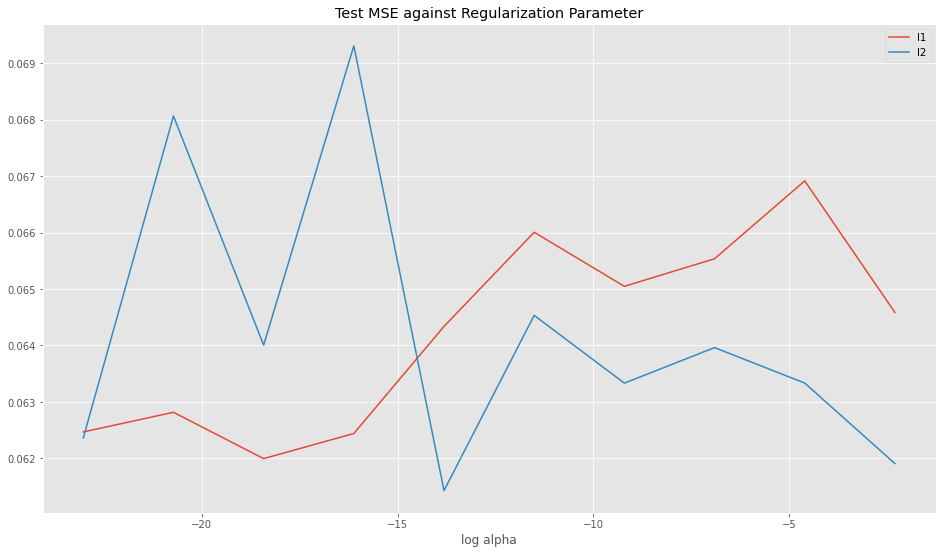

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlabel("log alpha")
ax.set_title("Test MSE against Regularization Parameter")
plt.plot(np.log(regularization_parameters), losses_l1, label="l1")
plt.plot(np.log(regularization_parameters), losses_l2, label="l2")
ax.legend()
plt.show()

Refined grid search

In [ ]:
regularization_parameters = 10 ** np.linspace(-7, -9, num = 10)
regularizations = [regularizers.l1(x) for x in regularization_parameters]
moneyness = np.log(original_df.strike_price/original_df.forward_price)

losses_l1 = []

for regularization in regularizations:
    # NN for X
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_X = Model([input_layer, weights_tensor], out_layer)
    model_X.compile(optimizer='adam', loss=weighted_loss_func)
    model_X.fit(x=[input_train, weights_train], y=output_train.level, batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test.level), verbose=0)

    # NN for Y
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Y = Model([input_layer, weights_tensor], out_layer)
    model_Y.compile(optimizer='adam', loss=weighted_loss_func)
    model_Y.fit(x=[input_train, weights_train], y=output_train["skew"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["skew"]), verbose=0)

    # NN for Z
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Z = Model([input_layer, weights_tensor], out_layer)
    model_Z.compile(optimizer='adam', loss=weighted_loss_func)
    model_Z.fit(x=[input_train, weights_train], y=output_train["convexity"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["convexity"]), verbose=0)

    #
    output_predict_X = model_X.predict([input_predict, input_predict])[:,0]
    output_predict_Y = model_Y.predict([input_predict, input_predict])[:,0]
    output_predict_Z = model_Z.predict([input_predict, input_predict])[:,0]

    #
    implied_volatility_alpha = output_predict_X - output_predict_Y*moneyness + output_predict_Z*moneyness**2
    loss_alpha = np.mean((original_df.impl_volatility - implied_volatility_alpha)**2)
    losses_l1.append(loss_alpha)
    print(loss_alpha)


0.06758028991401982
0.06526961817680385
0.06523702169248591
0.06388211941248567
0.0664048713748689
0.06718952814095655
0.06395325565670995
0.06278687319162146
0.06652329754023815
0.0623032549095213


In [ ]:
regularization_parameters = 10 ** np.linspace(-6, -8, num = 10)
regularizations = [regularizers.l2(x) for x in regularization_parameters]
moneyness = np.log(original_df.strike_price/original_df.forward_price)

losses_l2 = []

for regularization in regularizations:
    # NN for X
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_X = Model([input_layer, weights_tensor], out_layer)
    model_X.compile(optimizer='adam', loss=weighted_loss_func)
    model_X.fit(x=[input_train, weights_train], y=output_train.level, batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test.level), verbose=0)

    # NN for Y
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Y = Model([input_layer, weights_tensor], out_layer)
    model_Y.compile(optimizer='adam', loss=weighted_loss_func)
    model_Y.fit(x=[input_train, weights_train], y=output_train["skew"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["skew"]), verbose=0)

    # NN for Z
    input_layer = Input(shape=(len(input_train.columns),))
    weights_tensor = Input(shape=(len(input_train.columns),))
    layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
    layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
    layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
    out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
    weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

    model_Z = Model([input_layer, weights_tensor], out_layer)
    model_Z.compile(optimizer='adam', loss=weighted_loss_func)
    model_Z.fit(x=[input_train, weights_train], y=output_train["convexity"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["convexity"]), verbose=0)

    #
    output_predict_X = model_X.predict([input_predict, input_predict])[:,0]
    output_predict_Y = model_Y.predict([input_predict, input_predict])[:,0]
    output_predict_Z = model_Z.predict([input_predict, input_predict])[:,0]

    #
    implied_volatility_alpha = output_predict_X - output_predict_Y*moneyness + output_predict_Z*moneyness**2
    loss_alpha = np.mean((original_df.impl_volatility - implied_volatility_alpha)**2)
    losses_l1.append(loss_alpha)
    print(loss_alpha)


0.06768277489652691
0.06456778555940626
0.0629834231348808
0.06144329463889489
0.06166094348179604
0.06037401644856615
0.061530878166538884
0.0677711758806929
0.062410853330018994
0.06756992045503912


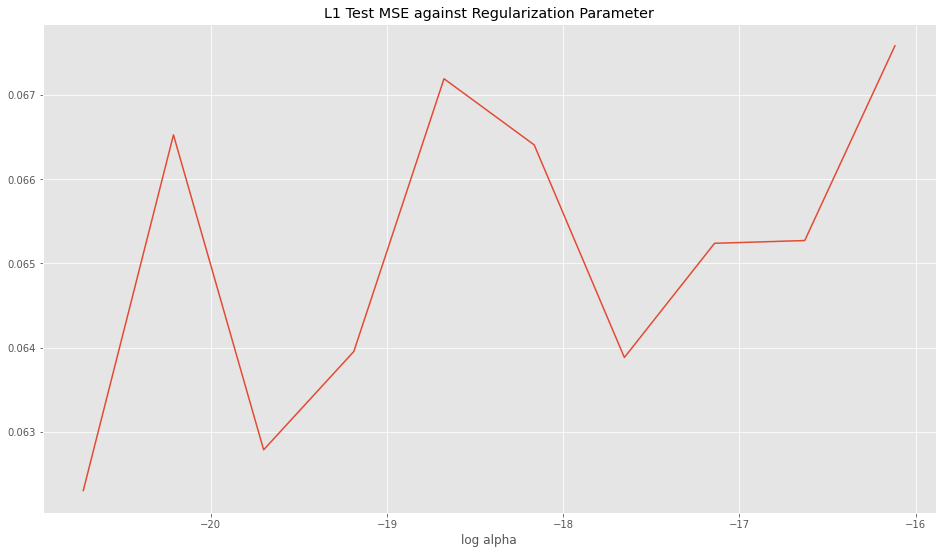

In [ ]:
losses_l1 = [0.06758028991401982,
0.06526961817680385,
0.06523702169248591, 
0.06388211941248567,
0.0664048713748689,
0.06718952814095655,
0.06395325565670995,
0.06278687319162146,
0.06652329754023815,
0.0623032549095213]
regularization_parameters = 10 ** np.linspace(-7, -9, num = 10)
# minimum at 1e-9

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlabel("log alpha")
ax.set_title("L1 Test MSE against Regularization Parameter")
plt.plot(np.log(regularization_parameters), losses_l1, label="l1")
#ax.legend()
plt.show()

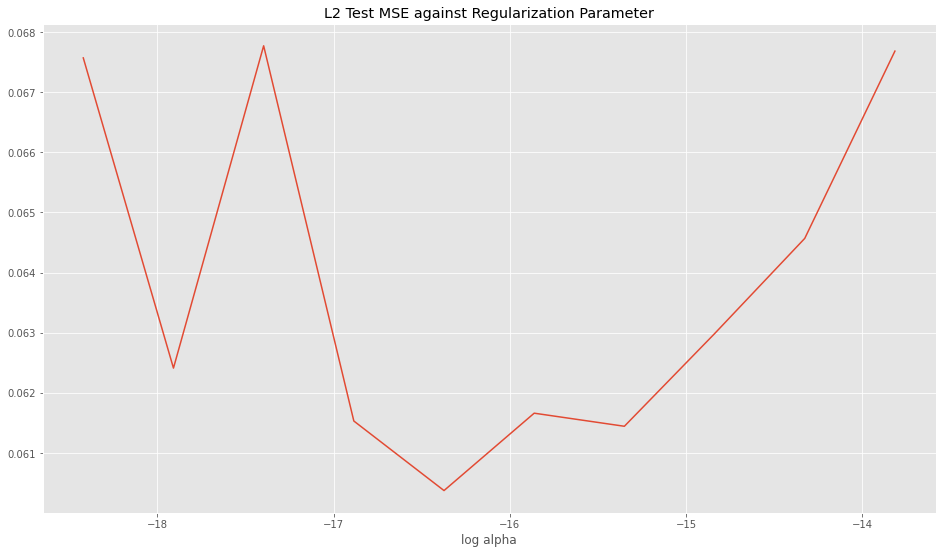

In [ ]:
losses_l2 = [0.06768277489652691,
0.06456778555940626,
0.0629834231348808,
0.06144329463889489,
0.06166094348179604,
0.06037401644856615,
0.061530878166538884,
0.0677711758806929,
0.062410853330018994,
0.06756992045503912]
regularization_parameters = 10 ** np.linspace(-6, -8, num = 10)
# minimum at 7.742636826811277e-08

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.set_xlabel("log alpha")
ax.set_title("L2 Test MSE against Regularization Parameter")
plt.plot(np.log(regularization_parameters), losses_l2, label="l2")
#ax.legend()
plt.show()

### Use optimal $\alpha$

In [ ]:
regularization = regularizers.l2(7.742636826811277e-08)

In [ ]:
# NN for X
input_layer = Input(shape=(len(input_train.columns),))
weights_tensor = Input(shape=(len(input_train.columns),))
layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

model_X = Model([input_layer, weights_tensor], out_layer)
model_X.compile(optimizer='adam', loss=weighted_loss_func)
model_X.summary()
model_X.fit(x=[input_train, weights_train], y=output_train.level, batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test.level))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
Train on 11144 samples, validate on 11145 samples
Epoch 1/10
11144/11144 [==============================] - 0s 40us/step 

In [ ]:
# NN for Y
input_layer = Input(shape=(len(input_train.columns),))
weights_tensor = Input(shape=(len(input_train.columns),))
layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

model_Y = Model([input_layer, weights_tensor], out_layer)
model_Y.compile(optimizer='adam', loss=weighted_loss_func)
model_Y.summary()
model_Y.fit(x=[input_train, weights_train], y=output_train["skew"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["skew"]))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
Train on 11144 samples, validate on 11145 samples
Epoch 1/10
11144/11144 [==============================] - 0s 38us/step 

In [ ]:
# NN for Z
input_layer = Input(shape=(len(input_train.columns),))
weights_tensor = Input(shape=(len(input_train.columns),))
layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)
weighted_loss_func = partial(weighted_loss, weights=weights_tensor)

model_Z = Model([input_layer, weights_tensor], out_layer)
model_Z.compile(optimizer='adam', loss=weighted_loss_func)
model_Z.summary()
model_Z.fit(x=[input_train, weights_train], y=output_train["convexity"], batch_size=100, epochs=10, validation_data=([input_test, weights_test], output_test["convexity"]))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
Train on 11144 samples, validate on 11145 samples
Epoch 1/10
11144/11144 [==============================] - 0s 39us/step 

## Performance evaluation

In [ ]:
original_df = pd.read_csv("/content/drive/My Drive/Data/Essentials_About_FB_Call_2011-01-01_2019-06-30.csv")
original_df.head()

,Unnamed: 0,strike_price,volume,impl_volatility,forward_price,underlying_adj_close_price,underlying_volume,VIX,underlying_volatility,T,t,tau,bid_ask_spread,option_price
0,8340,23.0,0,1.360353,30.771671,30.77,14122000.0,16.799999,0.702614,8,4,4,0.20,7.800
1,8343,26.0,0,0.850917,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.20,4.800
2,8344,27.0,0,0.687697,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.20,3.800
3,8345,28.0,0,0.599323,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.15,2.825
4,8346,29.0,773,0.504407,30.771671,30.77,14122000.0,16.799999,0.702614,4,0,4,0.05,1.875


In [ ]:
input_predict = original_df[['underlying_adj_close_price', 'underlying_volume', 'VIX', 'underlying_volatility', 'tau']]
input_predict = (input_predict - input_predict.mean()) / input_predict.std()

In [ ]:
input_predict.head()

,underlying_adj_close_price,underlying_volume,VIX,underlying_volatility,tau
0,-1.67162,-0.705724,0.427391,2.793735,-0.804919
1,-1.67162,-0.705724,0.427391,2.793735,-0.804919
2,-1.67162,-0.705724,0.427391,2.793735,-0.804919
3,-1.67162,-0.705724,0.427391,2.793735,-0.804919
4,-1.67162,-0.705724,0.427391,2.793735,-0.804919


In [ ]:
output_predict_X = model_X.predict([input_predict, input_predict])
output_predict_Y = model_Y.predict([input_predict, input_predict])
output_predict_Z = model_Z.predict([input_predict, input_predict])

In [ ]:
original_df['level_l2'] = output_predict_X
original_df['skew_l2'] = output_predict_Y
original_df['convexity_l2'] = output_predict_Z

In [ ]:
original_df.head()

,Unnamed: 0,strike_price,volume,impl_volatility,forward_price,underlying_adj_close_price,underlying_volume,VIX,underlying_volatility,T,t,tau,bid_ask_spread,option_price,level_l1,skew_l1,convexity_l1,fitted_implied_volatility_l1,level_l2,skew_l2,convexity_l2
0,8340,23.0,0,1.360353,30.771671,30.77,14122000.0,16.799999,0.702614,8,4,4,0.20,7.800,0.445288,0.002069,0.098833,0.454266,0.47961,0.010152,0.054828
1,8343,26.0,0,0.850917,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.20,4.800,0.445288,0.002069,0.098833,0.448443,0.47961,0.010152,0.054828
2,8344,27.0,0,0.687697,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.20,3.800,0.445288,0.002069,0.098833,0.447249,0.47961,0.010152,0.054828
3,8345,28.0,0,0.599323,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.15,2.825,0.445288,0.002069,0.098833,0.446364,0.47961,0.010152,0.054828
4,8346,29.0,773,0.504407,30.771671,30.77,14122000.0,16.799999,0.702614,4,0,4,0.05,1.875,0.445288,0.002069,0.098833,0.445759,0.47961,0.010152,0.054828


In [ ]:
def fitted_implied_volatility(X, Y, Z, K, F):
    moneyness = np.log(K/F)
    iv = X - Y*moneyness + Z*moneyness**2
    return iv

In [ ]:
original_df['fitted_implied_volatility_l2'] = original_df.apply(lambda row: fitted_implied_volatility(row.level_l2, row['skew_l2'], row.convexity_l2, row.strike_price, row.forward_price), axis=1)

In [ ]:
original_df.head()

,Unnamed: 0,strike_price,volume,impl_volatility,forward_price,underlying_adj_close_price,underlying_volume,VIX,underlying_volatility,T,t,tau,bid_ask_spread,option_price,level_l1,skew_l1,convexity_l1,fitted_implied_volatility_l1,level_l2,skew_l2,convexity_l2,fitted_implied_volatility_l2
0,8340,23.0,0,1.360353,30.771671,30.77,14122000.0,16.799999,0.702614,8,4,4,0.20,7.800,0.445288,0.002069,0.098833,0.454266,0.47961,0.010152,0.054828,0.487211
1,8343,26.0,0,0.850917,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.20,4.800,0.445288,0.002069,0.098833,0.448443,0.47961,0.010152,0.054828,0.482877
2,8344,27.0,0,0.687697,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.20,3.800,0.445288,0.002069,0.098833,0.447249,0.47961,0.010152,0.054828,0.481874
3,8345,28.0,0,0.599323,30.771671,30.77,14122000.0,16.799999,0.702614,7,3,4,0.15,2.825,0.445288,0.002069,0.098833,0.446364,0.47961,0.010152,0.054828,0.481056
4,8346,29.0,773,0.504407,30.771671,30.77,14122000.0,16.799999,0.702614,4,0,4,0.05,1.875,0.445288,0.002069,0.098833,0.445759,0.47961,0.010152,0.054828,0.480404


In [ ]:
loss = np.mean((original_df.impl_volatility - original_df.fitted_implied_volatility_l2)**2)

In [ ]:
loss

0.06359119925436733

In [ ]:
loss = np.mean((original_df.impl_volatility - original_df.fitted_implied_volatility_l1)**2)

In [ ]:
loss

0.06526844548909194

## Download and Load


In [ ]:
original_df.to_csv("original_df.csv")
files.download("original_df.csv")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 49454, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [ ]:
original_df = pd.read_csv("/content/drive/My Drive/Data/NN_fitted_vol_surface.csv", index_col=0)
original_df.head()

,Unnamed: 0.1,strike_price,volume,impl_volatility,forward_price,underlying_adj_close_price,underlying_volume,VIX,underlying_volatility,T,t,tau,bid_ask_spread,option_price,level_l1,skew_l1,convexity_l1,fitted_implied_volatility_l1,level_l2,skew_l2,convexity_l2,fitted_implied_volatility_l2
0,8340,23.0,0,1.360353,30.771671,30.77,14122000.0,16.799999,0.702614,8.0,4.0,4.0,0.20,7.800,0.445288,0.002069,0.098833,0.454266,0.47961,0.010152,0.054828,0.487211
1,8343,26.0,0,0.850917,30.771671,30.77,14122000.0,16.799999,0.702614,7.0,3.0,4.0,0.20,4.800,0.445288,0.002069,0.098833,0.448443,0.47961,0.010152,0.054828,0.482877
2,8344,27.0,0,0.687697,30.771671,30.77,14122000.0,16.799999,0.702614,7.0,3.0,4.0,0.20,3.800,0.445288,0.002069,0.098833,0.447249,0.47961,0.010152,0.054828,0.481874
3,8345,28.0,0,0.599323,30.771671,30.77,14122000.0,16.799999,0.702614,7.0,3.0,4.0,0.15,2.825,0.445288,0.002069,0.098833,0.446364,0.47961,0.010152,0.054828,0.481056
4,8346,29.0,773,0.504407,30.771671,30.77,14122000.0,16.799999,0.702614,4.0,0.0,4.0,0.05,1.875,0.445288,0.002069,0.098833,0.445759,0.47961,0.010152,0.054828,0.480404


In [ ]:
# Take 2017 data
big_df = pd.read_csv("/content/drive/My Drive/Data/All_About_FB_Call_2011-01-01_2019-06-30.csvb", index_col=0)

In [ ]:
big_df.head()

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,timeStampDate,underlying_adj_close_price,underlying_close_price,underlying_high_price,underlying_low_price,underlying_open_price,underlying_volume,T,t,bid_ask_spread,tau,moneyness,option_price
8340,154402,20120702,20120706,20120628,C,23.0,7.70,7.9,0,1.360353,82494682,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,8,4,0.20,4,0.747441,7.800
8343,154402,20120702,20120706,20120629,C,26.0,4.70,4.9,0,0.850917,82494685,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,7,3,0.20,4,0.844933,4.800
8344,154402,20120702,20120706,20120629,C,27.0,3.70,3.9,0,0.687697,82494686,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,7,3,0.20,4,0.877430,3.800
8345,154402,20120702,20120706,20120629,C,28.0,2.75,2.9,0,0.599323,82494687,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,7,3,0.15,4,0.909928,2.825
8346,154402,20120702,20120706,20120702,C,29.0,1.85,1.9,773,0.504407,82494688,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,4,0,0.05,4,0.942425,1.875


In [ ]:
big_df[(big_df["date"]>=20170000) & (big_df["date"]<20180000)]

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,timeStampDate,underlying_adj_close_price,underlying_close_price,underlying_high_price,underlying_low_price,underlying_open_price,underlying_volume,T,t,bid_ask_spread,tau,moneyness,option_price
540478,154402,20170103,20170106,20170103,C,112.0,4.80,4.95,188,0.205689,113970627,116.867046,0,FACEBOOK INC,A,2017-01-03,116.860001,116.860001,117.839996,115.510002,116.029999,20663900.0,3,0,0.15,3,0.958354,4.875
540479,154402,20170103,20170106,20170103,C,113.0,3.85,4.00,86,0.233710,113970628,116.867046,0,FACEBOOK INC,A,2017-01-03,116.860001,116.860001,117.839996,115.510002,116.029999,20663900.0,3,0,0.15,3,0.966911,3.925
540480,154402,20170103,20170106,20170103,C,114.0,2.94,3.05,566,0.225377,113970629,116.867046,0,FACEBOOK INC,A,2017-01-03,116.860001,116.860001,117.839996,115.510002,116.029999,20663900.0,3,0,0.11,3,0.975467,2.995
540481,154402,20170103,20170106,20170103,C,115.0,2.10,2.15,3850,0.214585,113970630,116.867046,0,FACEBOOK INC,A,2017-01-03,116.860001,116.860001,117.839996,115.510002,116.029999,20663900.0,3,0,0.05,3,0.984024,2.125
540482,154402,20170103,20170106,20170103,C,116.0,1.35,1.40,4612,0.207532,113970631,116.867046,0,FACEBOOK INC,A,2017-01-03,116.860001,116.860001,117.839996,115.510002,116.029999,20663900.0,3,0,0.05,3,0.992581,1.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685640,154402,20171229,20200117,20171229,C,225.0,12.10,16.25,5,0.267957,117999152,184.155175,0,FACEBOOK INC,A,2017-12-29,176.460007,176.460007,178.850006,176.460007,178.000000,10261500.0,749,0,4.15,749,1.221796,14.175
685641,154402,20171229,20200117,20171229,C,230.0,11.00,15.05,8,0.267395,118014168,184.155175,0,FACEBOOK INC,A,2017-12-29,176.460007,176.460007,178.850006,176.460007,178.000000,10261500.0,749,0,4.05,749,1.248947,13.025
685642,154402,20171229,20200117,20171229,C,240.0,8.90,12.95,10,0.265742,118014169,184.155175,0,FACEBOOK INC,A,2017-12-29,176.460007,176.460007,178.850006,176.460007,178.000000,10261500.0,749,0,4.05,749,1.303249,10.925
685643,154402,20171229,20200117,20171229,C,250.0,9.00,11.15,9,0.275393,118014170,184.155175,0,FACEBOOK INC,A,2017-12-29,176.460007,176.460007,178.850006,176.460007,178.000000,10261500.0,749,0,2.15,749,1.357551,10.075


In [ ]:
big_df.loc[689770:689771,:]

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,timeStampDate,underlying_adj_close_price,underlying_close_price,underlying_high_price,underlying_low_price,underlying_open_price,underlying_volume,T,t,bid_ask_spread,tau,moneyness,option_price
689770,154402,20180111,20191220,20171204,C,105.0,88.35,92.4,0,0.355260,117250671,195.785543,0,FACEBOOK INC,A,2018-01-11,187.770004,187.770004,188.399994,187.380005,188.399994,9588600.0,746,38,4.05,708,0.536301,90.375
689771,154402,20180111,20191220,20180104,C,110.0,84.05,88.0,0,0.345807,117250672,195.785543,0,FACEBOOK INC,A,2018-01-11,187.770004,187.770004,188.399994,187.380005,188.399994,9588600.0,715,7,3.95,708,0.561839,86.025


## Plot

In [ ]:
original_df["moneyness"] = original_df.strike_price / original_df.forward_price
plot_df = original_df[(original_df["Unnamed: 0.1"]>=540478) & (original_df["Unnamed: 0.1"]<689770)]

In [ ]:
normal_plot_df = plot_df[plot_df["impl_volatility"] < 0.35]

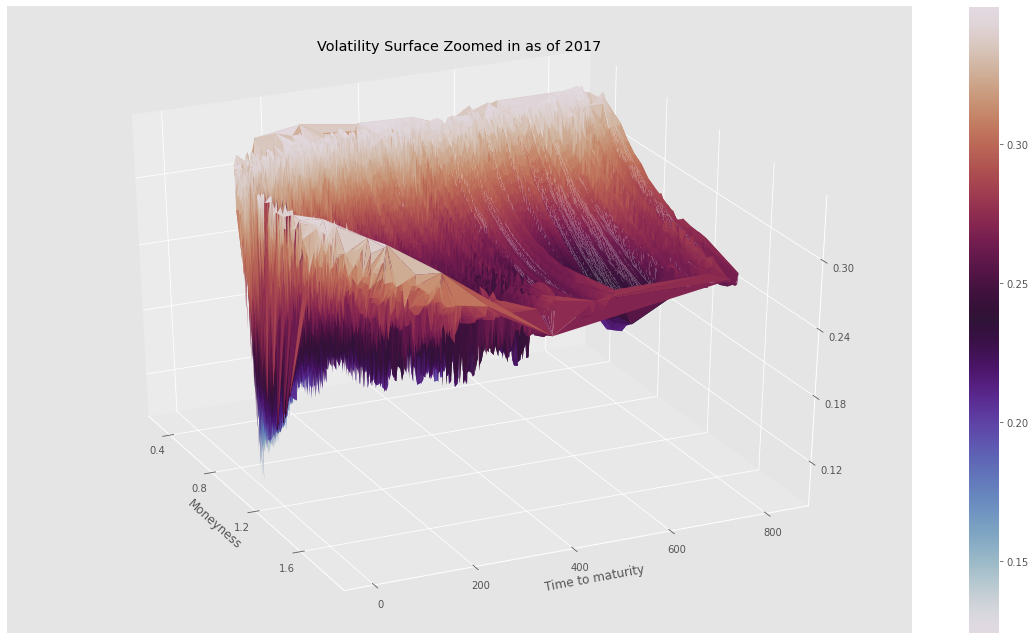

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(normal_plot_df.moneyness), np.asarray(normal_plot_df.tau), np.asarray(normal_plot_df.impl_volatility), cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Volatility Surface Zoomed in as of 2017")
#ax.set_zlim((0.15, 0.35))
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

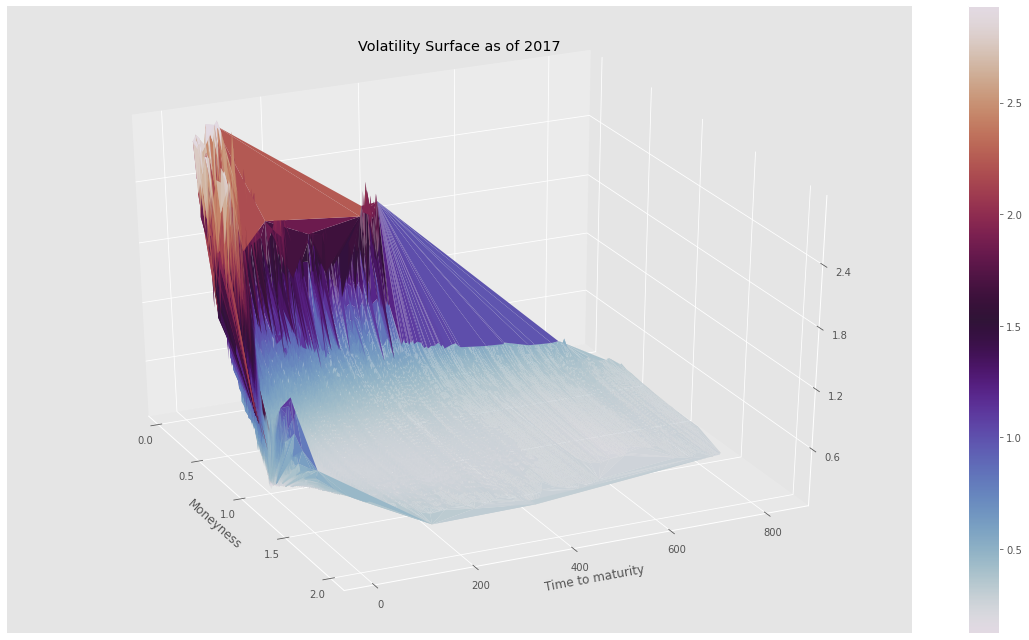

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(plot_df.moneyness), np.asarray(plot_df.tau), np.asarray(plot_df.impl_volatility), cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Volatility Surface as of 2017")
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

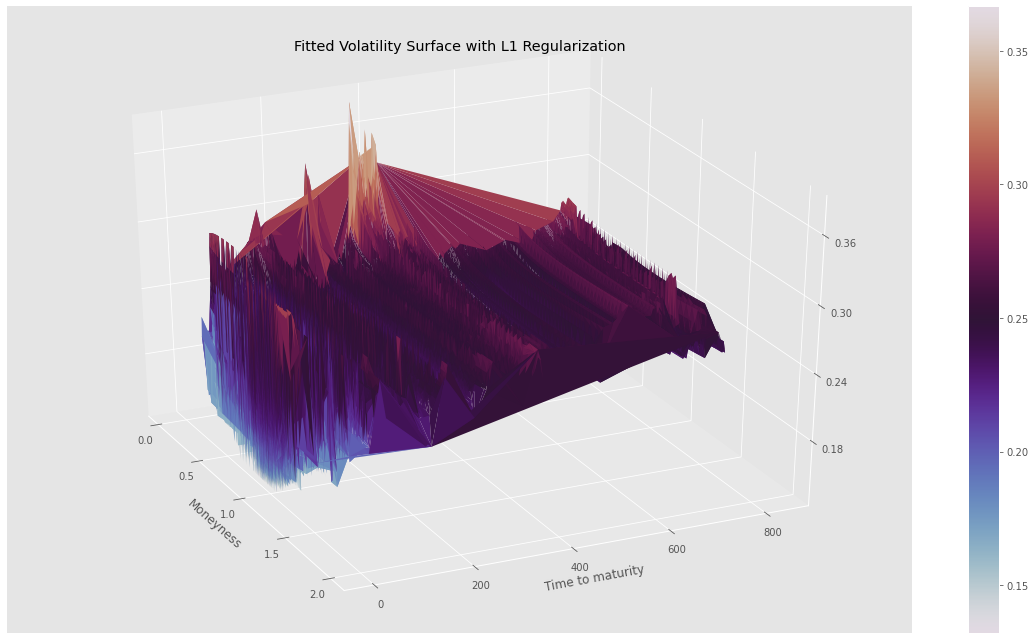

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(plot_df.moneyness), np.asarray(plot_df.tau), np.asarray(plot_df.fitted_implied_volatility_l1), cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Fitted Volatility Surface with L1 Regularization")
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

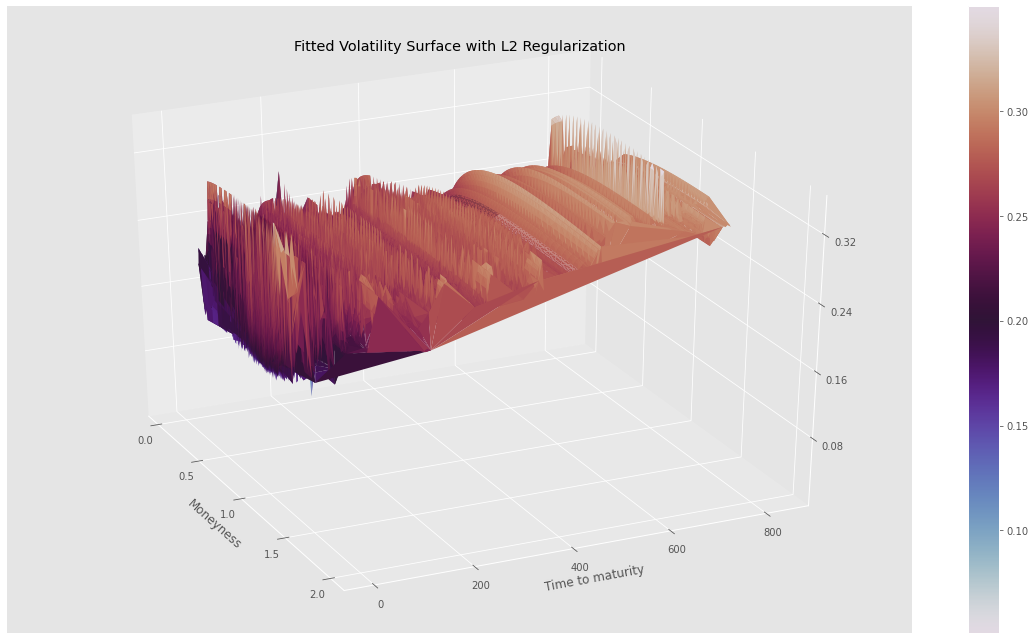

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(plot_df.moneyness), np.asarray(plot_df.tau), np.asarray(plot_df.fitted_implied_volatility_l2), cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Fitted Volatility Surface with L2 Regularization")
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

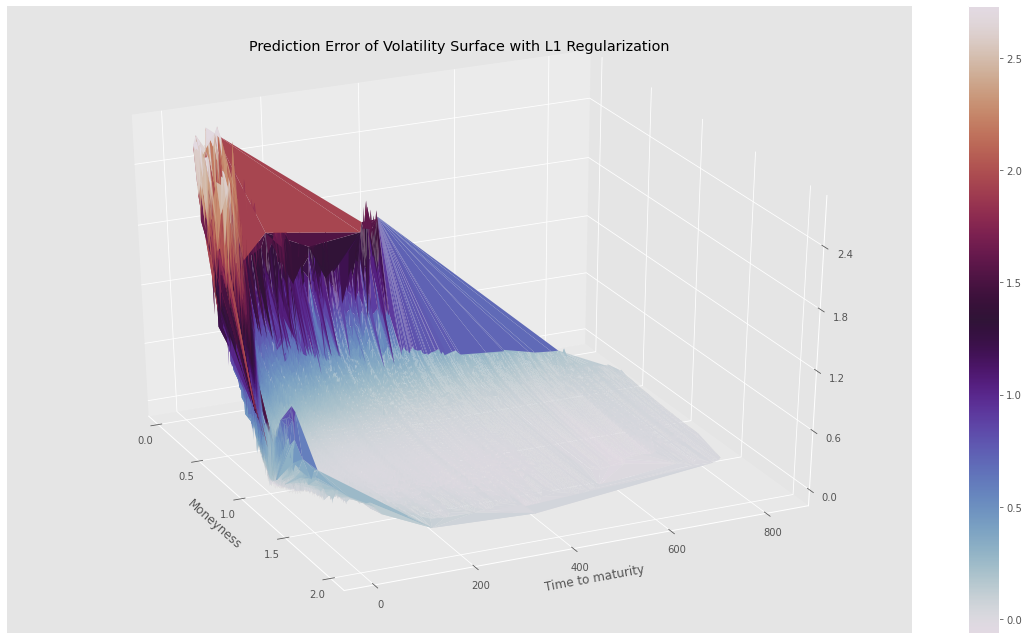

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(plot_df.moneyness), np.asarray(plot_df.tau), np.asarray(plot_df.impl_volatility-plot_df.fitted_implied_volatility_l1), cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Prediction Error of Volatility Surface with L1 Regularization")
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

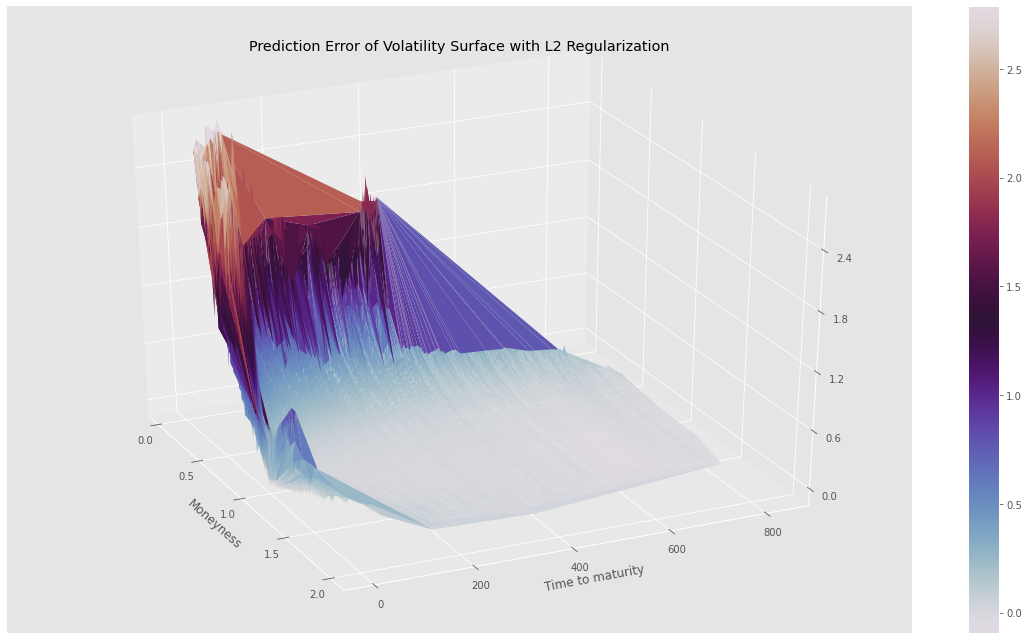

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(plot_df.moneyness), np.asarray(plot_df.tau), np.asarray(plot_df.impl_volatility-plot_df.fitted_implied_volatility_l2), cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Prediction Error of Volatility Surface with L2 Regularization")
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

## Non-arbitrage

In [ ]:
k = original_df.strike_price
x = np.log(original_df.strike_price/original_df.forward_price)
Xi = original_df.fitted_implied_volatility_l2

In [ ]:
Phi1 = np.exp(-((-x/Xi+Xi/2)**2/2))
Phi2 = np.exp(-((-x/Xi-Xi/2)**2/2))
Bdkdk = 1/(k**2*Xi)*(1/(np.sqrt(2*np.pi))*Phi1)*(1/2+x/Xi**2)+1/(k**2*Xi)*(1/(np.sqrt(2*np.pi))*Phi2)*(1/2-x/Xi**2)
DC = Bdkdk/((1/(np.sqrt(2*np.pi))*Phi1)/(k**2*Xi))

In [ ]:
np.min(DC)

0.9682523446341742

Text(0.5, 1.0, 'Non-arbitrage Positivity condition check for L2 Regularized NNDIVS')

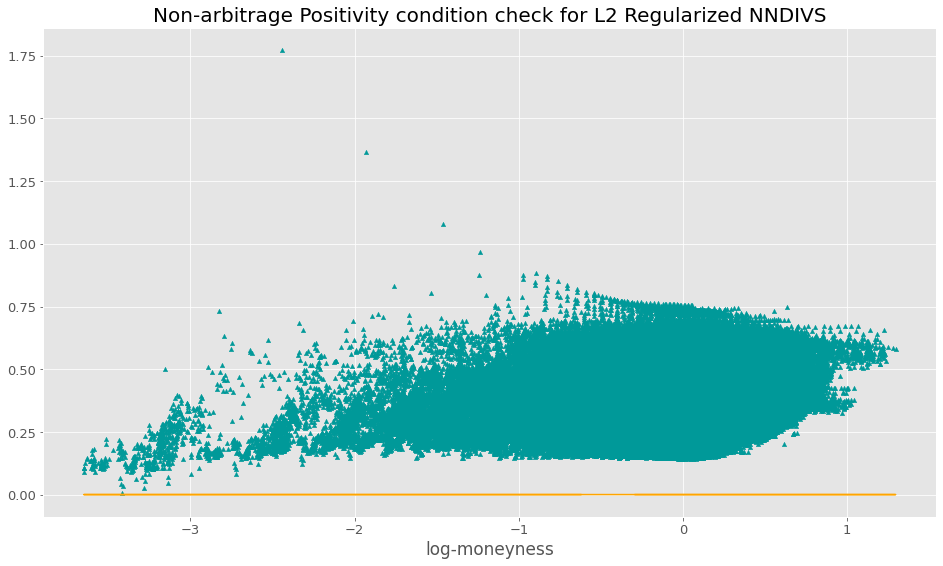

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
plt.scatter(x, Xi, c="#009999", marker="^", s=19)
plt.plot(x, np.zeros(len(x)), c="orange")
ax.set_xlabel("log-moneyness", fontsize=17)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
ax.set_title("Non-arbitrage Positivity condition check for L2 Regularized NNDIVS", fontsize=20)

Text(0.5, 1.0, 'Non-arbitrage Durrleman’s Condition check for L2 Regularized NNDIVS')

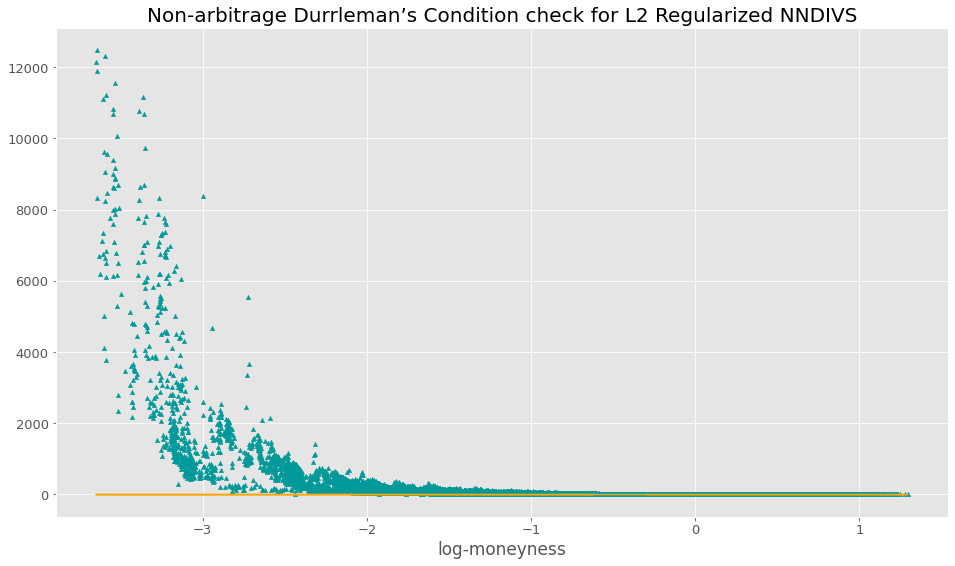

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
plt.scatter(x, DC, c="#009999", marker="^", s=19)
plt.plot(x, np.zeros(len(x)), c="orange")
ax.set_xlabel("log-moneyness", fontsize=17)
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
ax.set_title("Non-arbitrage Durrleman’s Condition check for L2 Regularized NNDIVS", fontsize=20)

# Neural Local Volatility Pricing

## Data Preparation

In [ ]:
NNlocal_df = pd.read_csv("/content/drive/My Drive/Data/All_About_FB_Call_2011-01-01_2019-06-30.csv", index_col=0)
NNlocal_df.head()

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,timeStampDate,underlying_adj_close_price,underlying_close_price,underlying_high_price,underlying_low_price,underlying_open_price,underlying_volume,VIX,underlying_volatility,T,t,tau,bid_ask_spread,moneyness,option_price
8340,154402,20120702,20120706,20120628,C,23.0,7.70,7.9,0,1.360353,82494682,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,16.799999,0.702614,8,4,4,0.20,0.747441,7.800
8343,154402,20120702,20120706,20120629,C,26.0,4.70,4.9,0,0.850917,82494685,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,16.799999,0.702614,7,3,4,0.20,0.844933,4.800
8344,154402,20120702,20120706,20120629,C,27.0,3.70,3.9,0,0.687697,82494686,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,16.799999,0.702614,7,3,4,0.20,0.877430,3.800
8345,154402,20120702,20120706,20120629,C,28.0,2.75,2.9,0,0.599323,82494687,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,16.799999,0.702614,7,3,4,0.15,0.909928,2.825
8346,154402,20120702,20120706,20120702,C,29.0,1.85,1.9,773,0.504407,82494688,30.771671,0,FACEBOOK INC,A,2012-07-02,30.77,30.77,31.73,30.549999,31.25,14122000.0,16.799999,0.702614,4,0,4,0.05,0.942425,1.875


In [ ]:
NNlocal_df = NNlocal_df.dropna(axis=0)

In [ ]:
train_local_df, test_local_df = train_test_split(NNlocal_df, test_size=0.5, random_state=42)

In [ ]:
input_local_train = train_local_df[['tau', 'moneyness']]
output_local_train = train_local_df[['impl_volatility']]
input_local_test = test_local_df[['tau', 'moneyness']]
output_local_test = test_local_df[['impl_volatility']]

In [ ]:
mean = input_local_test.mean()
std = input_local_test.std()

input_local_train = (input_local_train - input_local_train.mean()) / input_local_train.std()
input_local_test = (input_local_test - input_local_test.mean()) / input_local_test.std()

## Fit Sigmoid NN

In [ ]:
# NN for X
regularization = None
input_layer = Input(shape=(2,))
layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
out_layer = Dense(1, activation="sigmoid", kernel_regularizer=regularization)(layer3)

NN_local = Model(input_layer, out_layer)
NN_local.compile(optimizer='adam', loss="mse", metrics=['mae'])
NN_local.summary()
NN_local.fit(x=input_local_train, y=output_local_train, batch_size=100, epochs=10, validation_data=(input_local_test, output_local_test))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
Train on 204517 samples, validate on 204517 samples
Epoch 1/10
204517/204517 [==============================] - 6s 27us/s

In [ ]:
fitted_local_test = NN_local.predict(input_local_test)[:,0]

In [ ]:
input_local_test = std * input_local_test + mean

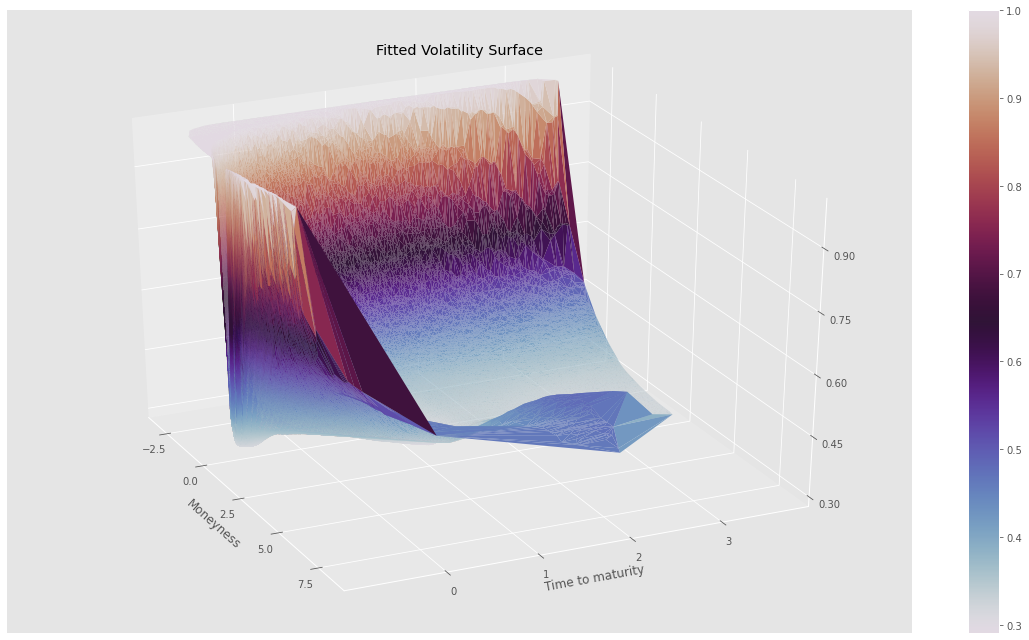

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(input_local_test.moneyness), np.asarray(input_local_test.tau), fitted_local_test, cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Fitted Volatility Surface")
#ax.set_zlim((0.15, 0.35))
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

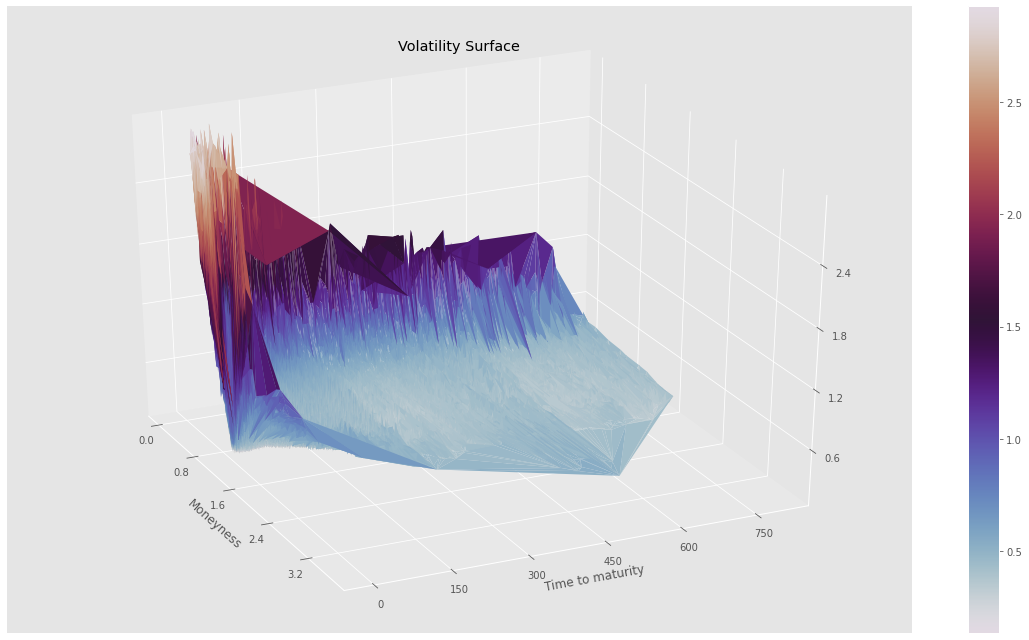

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(input_local_test.moneyness), np.asarray(input_local_test.tau), output_local_test.impl_volatility, cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Volatility Surface")
#ax.set_zlim((0.15, 0.35))
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

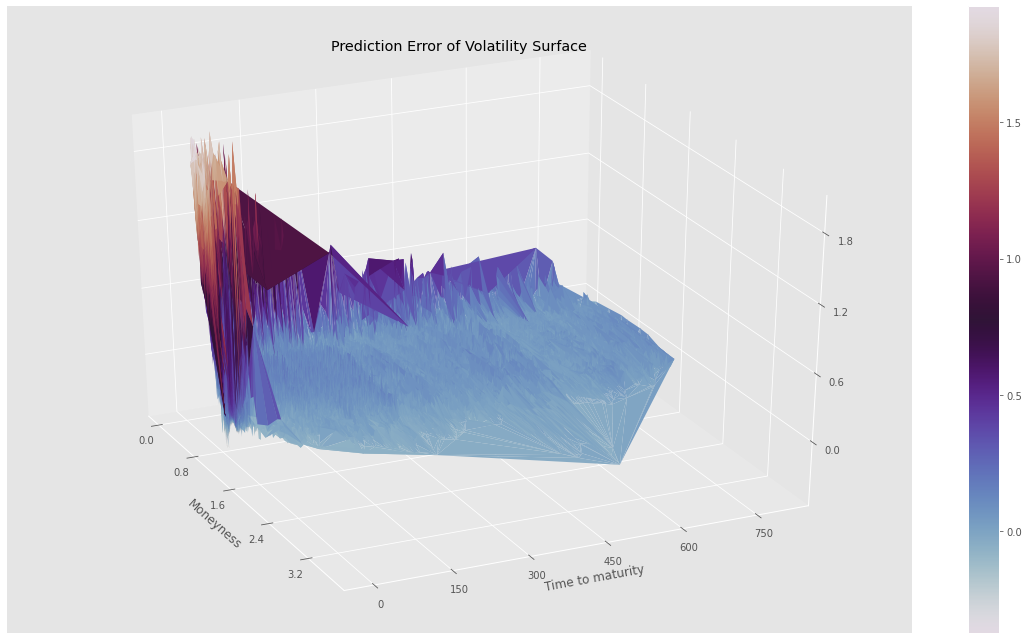

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(input_local_test.moneyness), np.asarray(input_local_test.tau), output_local_test.impl_volatility-fitted_local_test, cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Prediction Error of Volatility Surface")
#ax.set_zlim((0.15, 0.35))
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

## Fit Linear NN

In [ ]:
# NN for X
regularization = None
input_layer = Input(shape=(2,))
layer1 = Dense(100, activation="relu", kernel_regularizer=regularization)(input_layer)
layer2 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer1)
layer3 = Dense(100, activation="relu", kernel_regularizer=regularization)(layer2)
out_layer = Dense(1, activation="linear", kernel_regularizer=regularization)(layer3)

NN_local = Model(input_layer, out_layer)
NN_local.compile(optimizer='adam', loss="mse", metrics=['mae'])
NN_local.summary()
NN_local.fit(x=input_local_train, y=output_local_train, batch_size=100, epochs=10, validation_data=(input_local_test, output_local_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
Train on 204517 samples, validate on 204517 samples
Epoch 1/10
204517/204517 [==============================] - 6s 27us/s

In [ ]:
fitted_local_test = NN_local.predict(input_local_test)[:,0]

In [ ]:
input_local_test = std * input_local_test + mean

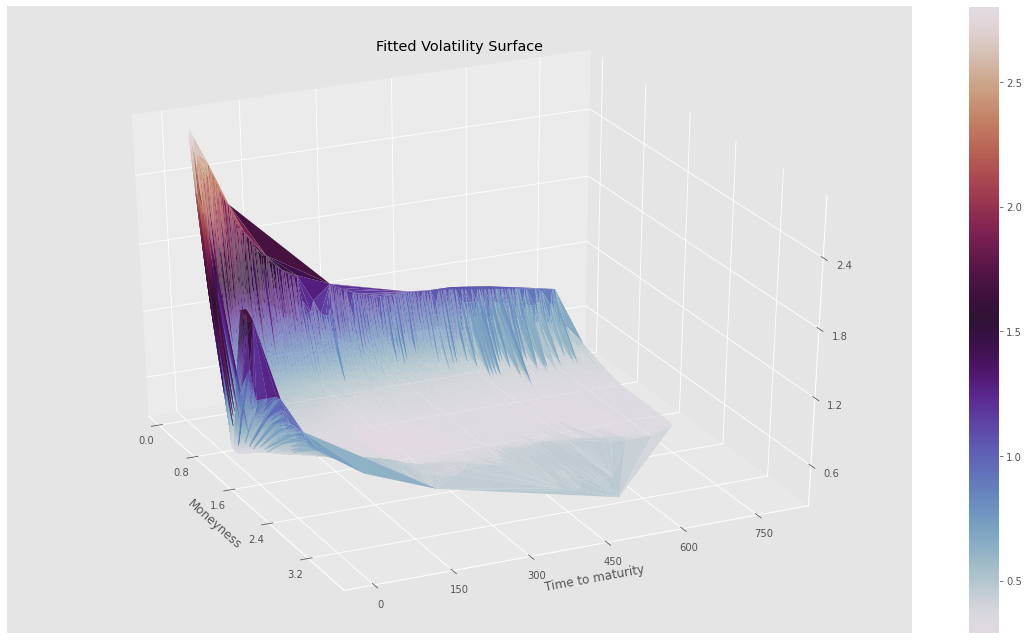

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(input_local_test.moneyness), np.asarray(input_local_test.tau), fitted_local_test, cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Fitted Volatility Surface")
ax.view_init(elev=30, azim=-25)
fig.tight_layout()
plt.show()

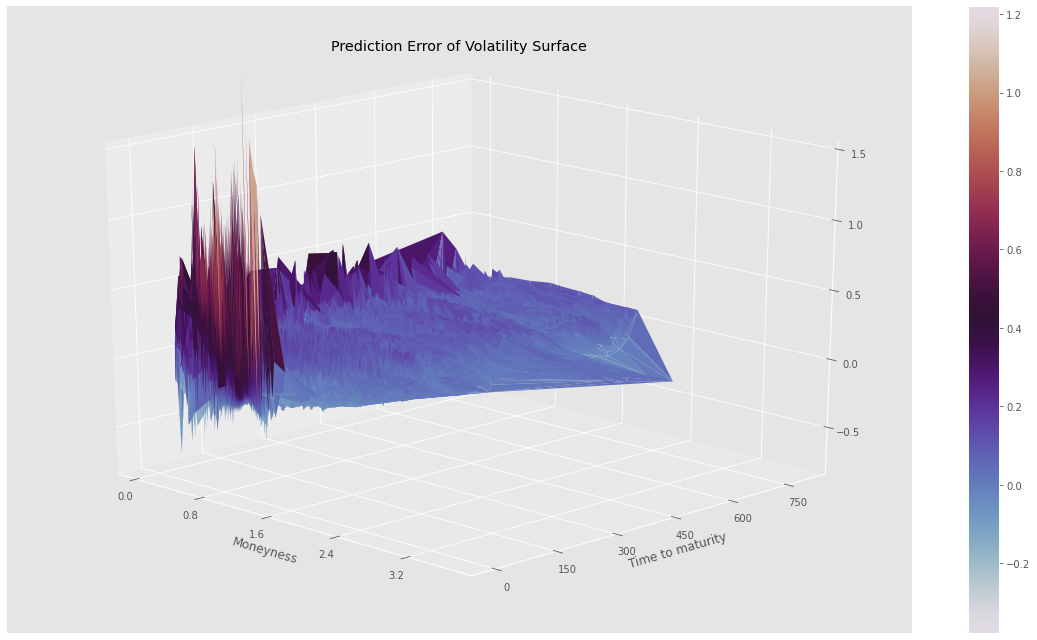

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.asarray(input_local_test.moneyness), np.asarray(input_local_test.tau), output_local_test.impl_volatility-fitted_local_test, cmap="twilight", linewidth=0)
fig.colorbar(surf)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel("Moneyness")
ax.set_ylabel("Time to maturity")
ax.set_title("Prediction Error of Volatility Surface")
ax.view_init(elev=20, azim=-45)
ax.set_zlim((-0.8, 1.5))
fig.tight_layout()
plt.show()

## Finite Difference (Explicit Scheme)

### Sigmoid NN

In [ ]:
K, r, T = 100, 0.00, 1
s_min, s_max = 0, 300
N, M = 1000, 100
sigma = np.zeros((N+1, M+1))
dt = T/N
dx = (s_max - s_min)/M
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)

for i in range(1,len(t)):
    for j in range(len(s)):
        tau = T - t[i]
        moneyness = K / s[j]
        sigma[i][j] = NN_local.predict(x=np.asarray([[tau, moneyness]]))[0,0]
sigma[0,:] = 1
sigma[:,0] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [ ]:
sigma

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.99996102, 0.80345917, ..., 0.30466038, 0.30480382,
        0.30494443],
       [1.        , 0.99996138, 0.80396485, ..., 0.30463886, 0.3047823 ,
        0.30492288],
       ...,
       [1.        , 1.        , 0.99894792, ..., 0.34147701, 0.34151611,
        0.34155443],
       [1.        , 1.        , 0.9989624 , ..., 0.34148398, 0.34152311,
        0.34156138],
       [1.        , 1.        , 0.99897683, ..., 0.34149095, 0.34153005,
        0.34156835]])

In [ ]:
# Running the explicit scheme

# Initial condition
v_ex = np.maximum(s - K, 0) # call option payoff

# Iteration of explicit scheme
for n in range(1,N+1):

  # Set up the vectors A, B and C
  A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
  B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
  C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

  # Setup the matrix L and I
  a_diag = np.concatenate([A[1:-1],[0]])
  b_diag = np.concatenate([[0],B[1:-1],[0]])
  c_diag = np.concatenate([[0],C[1:-1]])
  L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
  I = np.identity(M+1)

  v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
  v_ex[0] = 0                           # Boundary operation at s_min
  v_ex[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

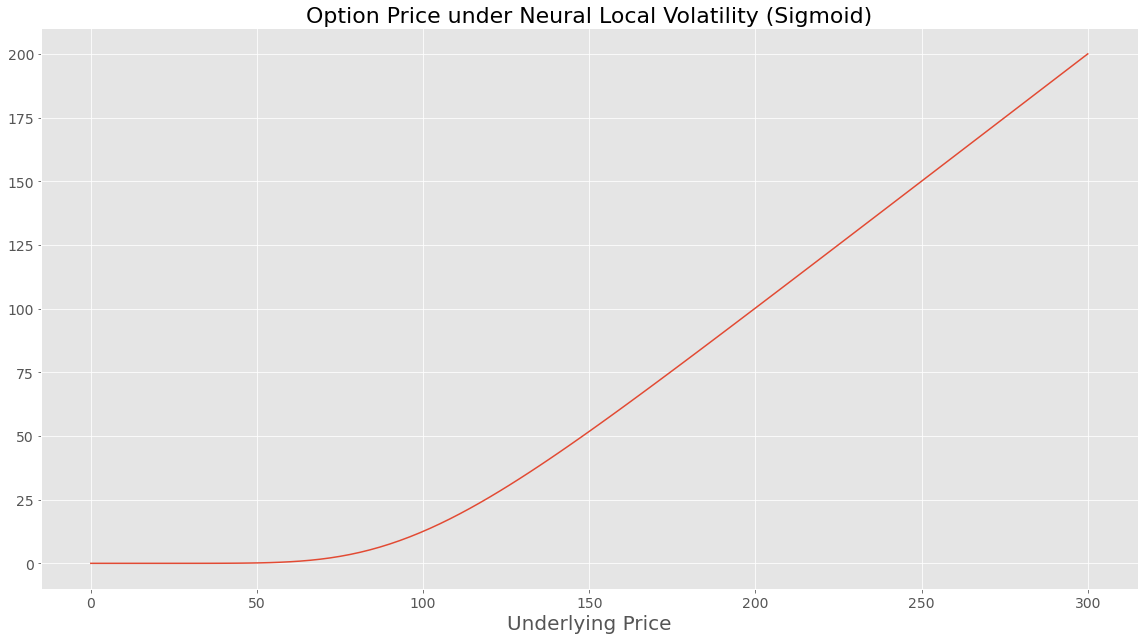

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
plt.plot(s, v_ex)
ax.set_xlabel("Underlying Price", fontsize=20)
ax.set_ylabel("")
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax.set_title("Option Price under Neural Local Volatility (Sigmoid)", fontsize=22)
fig.tight_layout()
plt.show()

### Linear NN

#### Compute implied volatility

In [ ]:
def BS_option_price_grid(K, r, T, s_min, s_max, N, M):
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)

    tau = np.zeros(len(t))
    for i in range(len(t)):
        tau[i] = t[i]
    tau = (tau - np.mean(tau)) / np.std(tau)

    moneyness = np.zeros(len(s))
    for i in range(len(s)):
        moneyness[i] = K / s[i]
    moneyness[0] = 100
    moneyness = (moneyness - np.mean(moneyness)) / np.std(moneyness)

    for i in range(len(t)):
        if i % 100 == 0:
            print(i)
        for j in range(len(s)):
            #sigma[i][j] = 0.2
            sigma[i][j] = NN_local.predict(x=np.asarray([[tau[i], moneyness[j]]]))[0,0]

    tau = np.zeros(len(t))
    for i in range(len(t)):
        tau[i] = t[i]
    moneyness = np.zeros(len(s))
    for i in range(len(s)):
        moneyness[i] = K / s[i]
    moneyness[0] = 100
    tau_grid, moneyness_grid = np.meshgrid(tau, moneyness)
    tau_grid = tau_grid.transpose()
    moneyness_grid = moneyness_grid.transpose()
    d1_grid = (-np.log(moneyness_grid) + sigma**2/2*tau_grid) / np.sqrt(tau_grid) / sigma
    d2_grid = d1_grid - sigma * np.sqrt(tau_grid)
    C_grid = norm.cdf(d1_grid) * (K / moneyness_grid) - norm.cdf(d2_grid) * K
    return C_grid

In [ ]:
K, r, T = 100, 0.00, 1
s_min, s_max = 0, 300
N, M = 2000, 100
sigma = np.zeros((N+1, M+1))
dt = T/N
dx = (s_max - s_min)/M

K_increment = 0.00001
K_mid = K
K_up = K_increment + K
K_down = -K_increment + K
C_grid_mid = BS_option_price_grid(K_mid, r, T, s_min, s_max, N, M)
C_grid_up = BS_option_price_grid(K_up, r, T, s_min, s_max, N, M)
C_grid_down = BS_option_price_grid(K_down, r, T, s_min, s_max, N, M)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
C_grid_up

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.93999900e+002, 1.96999900e+002, 1.99999900e+002],
       [1.86712250e-156, 5.84922006e-026, 5.62925511e-018, ...,
        1.94400949e+002, 1.97380158e+002, 2.00360516e+002],
       [4.18747288e-080, 8.52498124e-014, 1.23076356e-009, ...,
        1.96912254e+002, 1.99829851e+002, 2.02750138e+002],
       ...,
       [2.97796970e-013, 1.18411695e-019, 1.82204827e-016, ...,
        1.94031573e+002, 1.97028846e+002, 2.00026361e+002],
       [3.02497182e-013, 1.21887375e-019, 1.84561411e-016, ...,
        1.94031686e+002, 1.97028951e+002, 2.00026458e+002],
       [3.07263736e-013, 1.25460439e-019, 1.86943711e-016, ...,
        1.94031800e+002, 1.97029056e+002, 2.00026555e+002]])

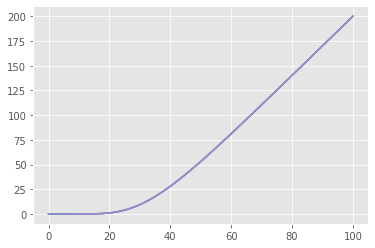

In [ ]:
plt.plot(C_grid_up[-1,:])
plt.plot(C_grid_mid[-1,:])
plt.plot(C_grid_down[-1,:])

In [ ]:
# calculate second derivative against K
CpartialKK = (C_grid_up - 2*C_grid_mid + C_grid_down) / (K_increment**2)
CpartialT = np.zeros((N+1, M+1))
CpartialT[:-1,:] =  (C_grid_mid[1:,:] - C_grid_mid[:-1,:]) / (T/N)
CpartialT[-1,:] = CpartialT[-2,:]

In [ ]:
CpartialT = np.maximum(CpartialT, 0)
CpartialKK = np.maximum(CpartialKK, 0.001)
local_vol_sigma = np.sqrt(2 * CpartialT / CpartialKK) / K

In [ ]:
local_vol_sigma

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.78005711e-13, 4.46758537e-10, 2.56318919e-08, ...,
        1.65274384e-01, 1.59150474e-01, 1.53193379e-01],
       [3.87754231e-13, 4.53929631e-10, 2.58486567e-08, ...,
        1.65414346e-01, 1.59223894e-01, 1.53297288e-01],
       [3.87754231e-13, 4.53929631e-10, 2.58486567e-08, ...,
        1.65414346e-01, 1.59223894e-01, 1.53297288e-01]])

In [ ]:
np.count_nonzero(~np.isnan(local_vol_sigma))

202101

In [ ]:
sigma = np.minimum(local_vol_sigma, 0.4)

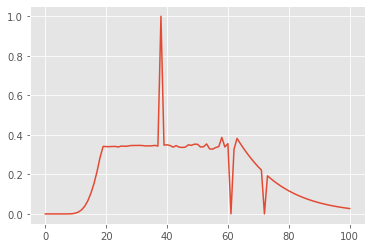

In [ ]:
plt.plot(sigma[1000])

In [ ]:
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)

# Running the explicit scheme

# Initial condition
v_ex = np.maximum(s - K, 0) # call option payoff

# Iteration of explicit scheme
for n in range(1,N+1):

  # Set up the vectors A, B and C
  A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
  B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
  C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

  # Setup the matrix L and I
  a_diag = np.concatenate([A[1:-1],[0]])
  b_diag = np.concatenate([[0],B[1:-1],[0]])
  c_diag = np.concatenate([[0],C[1:-1]])
  L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
  I = np.identity(M+1)

  v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
  v_ex[0] = 0                           # Boundary operation at s_min
  v_ex[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

In [ ]:
v_ex

array([0.00000000e+00, 1.22102035e-45, 2.62204607e-35, 4.64381471e-28,
       1.15950989e-22, 1.58451897e-18, 2.65674460e-15, 9.37446581e-13,
       9.23008011e-11, 3.00460938e-09, 5.81177286e-08, 3.63053633e-06,
       1.68307489e-04, 2.59579613e-03, 1.55395125e-02, 4.99931040e-02,
       1.12994704e-01, 2.06900552e-01, 3.42208072e-01, 5.29236697e-01,
       7.78731045e-01, 1.10095770e+00, 1.50631048e+00, 2.00340337e+00,
       2.59954064e+00, 3.30402023e+00, 4.11854396e+00, 5.04951351e+00,
       6.09360989e+00, 7.25665318e+00, 8.53587453e+00, 9.92917672e+00,
       1.14342573e+01, 1.30490745e+01, 1.47738233e+01, 1.65979679e+01,
       1.85156523e+01, 2.05221204e+01, 2.26122013e+01, 2.47803600e+01,
       2.70215312e+01, 2.93314137e+01, 3.17038171e+01, 3.41345692e+01,
       3.66170441e+01, 3.91482975e+01, 4.17240578e+01, 4.43388233e+01,
       4.69970552e+01, 4.96872253e+01, 5.24073452e+01, 5.51572728e+01,
       5.79324161e+01, 6.07303704e+01, 6.35491528e+01, 6.63863763e+01,
      

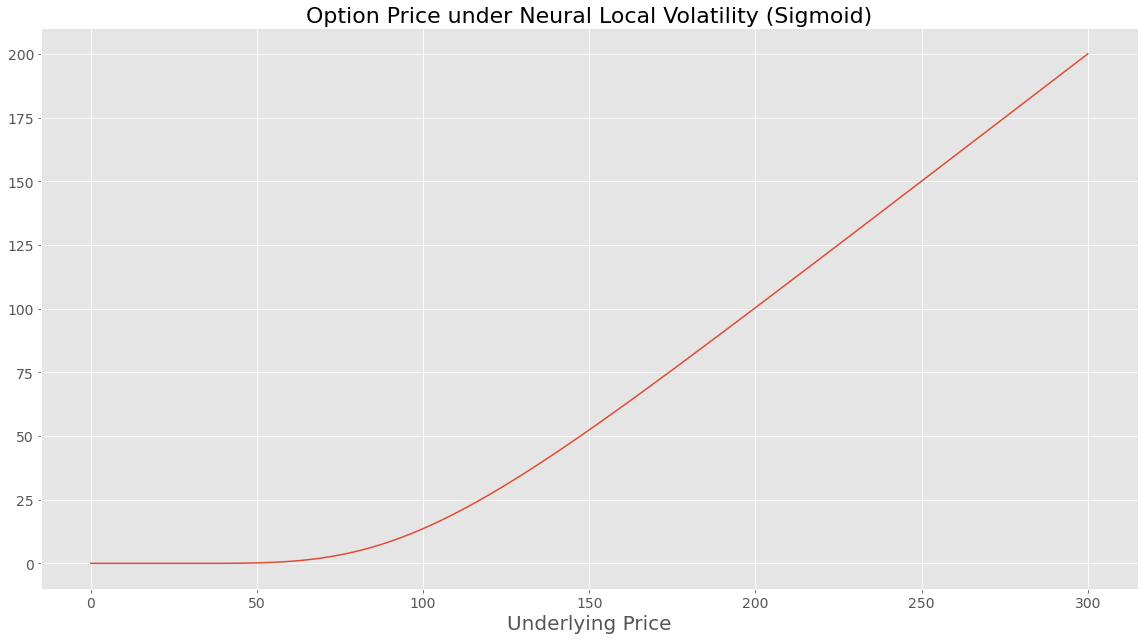

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
plt.plot(s, v_ex)
ax.set_xlabel("Underlying Price", fontsize=20)
ax.set_ylabel("")
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax.set_title("Option Price under Neural Local Volatility (Sigmoid)", fontsize=22)
fig.tight_layout()
plt.show()

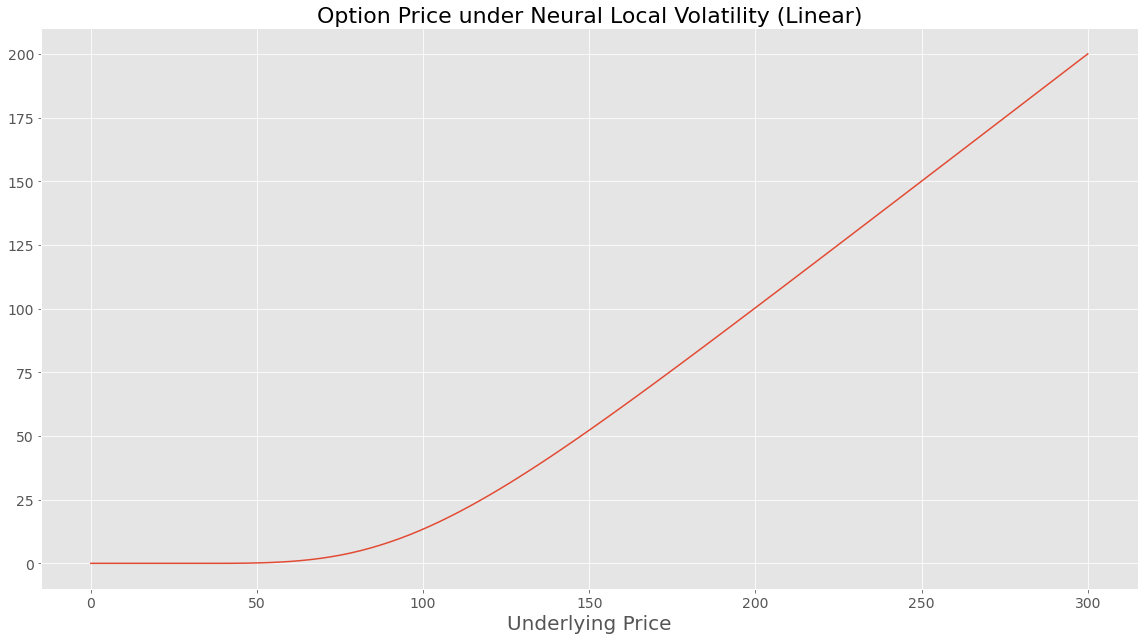

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
plt.plot(s, v_ex)
ax.set_xlabel("Underlying Price", fontsize=20)
ax.set_ylabel("")
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
ax.set_title("Option Price under Neural Local Volatility (Linear)", fontsize=22)
fig.tight_layout()
plt.show()